# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "data/train.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape[:-1]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

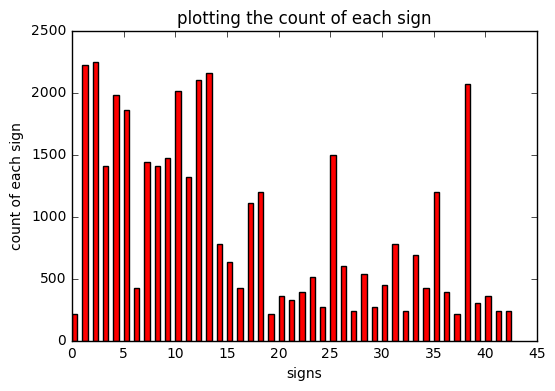

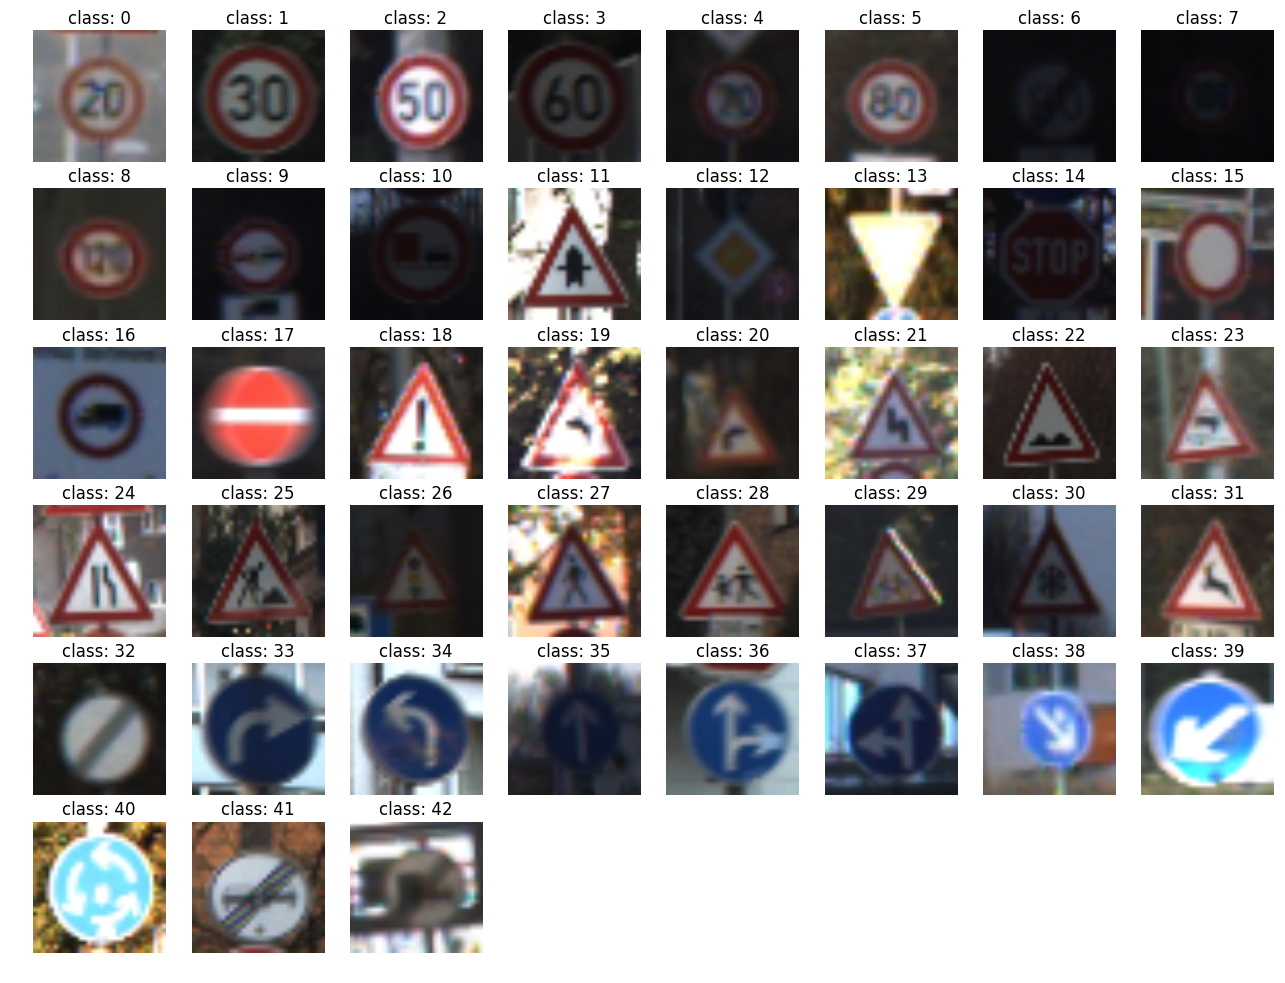

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import numpy as np
import random
# Visualizations will be shown in the notebook.
%matplotlib inline

fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(y_train), 0.5, color='r')
ax.set_xlabel('signs')
ax.set_ylabel('count of each sign')
ax.set_title('plotting the count of each sign')
plt.show()

plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(y_train == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(X_train[i])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
# First Implementation
import tensorflow as tf
from sklearn.utils import shuffle

EPOCHS = 10
BATCH_SIZE = 128

def weight_variable(shape):
    initial = tf.truncated_normal(shape, mean=0, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.zeros(shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='SAME')
    
def conv_net(x):
    # Convolution Layer 1. 32x32x3 -> 32x32x6
    conv1_W = weight_variable([5, 5, 3, 6])
    conv1_b = bias_variable([6])
    conv1 = conv2d(x, conv1_W, conv1_b)
    
    # Pooling Layer 1. 32x32x6 -> 16x16x6
    conv1 = maxpool2d(conv1)
    
    # Convolution Layer 2. 16x16x6 -> 16x16x16
    conv2_W = weight_variable([5, 5, 6, 16])
    conv2_b = bias_variable([16])
    conv2 = conv2d(conv1, conv2_W, conv2_b)
    
    # Pooling Layer 2. 16x16x16 -> 8x8x16
    conv2 = maxpool2d(conv2)
    
    # Fully Connected Layer 1. 4x4x32 -> 120
    fc1_W = weight_variable([8*8*16, 120])
    fc1_b = bias_variable([120])
    fc1 = tf.reshape(conv2, [-1, 8*8*16])
    fc1 = tf.nn.relu(tf.matmul(fc1, fc1_W) + fc1_b)

    # Fully Connected Layer 2. 120 -> 84
    fc2_W = weight_variable([120, 84])
    fc2_b = bias_variable([84])
    fc2 = tf.nn.relu(tf.matmul(fc1, fc2_W) + fc2_b)
    
    # Fully Connected Layer 3. 84 -> 43
    fc3_W = weight_variable([84, 43])
    fc3_b = bias_variable([43])
    fc3 = tf.matmul(fc2, fc3_W) + fc3_b
    return fc3

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

logits = conv_net(x)
loss_operation = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy, total_loss = 0, 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy =  sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * batch_x.shape[0])
        total_loss     += (loss * batch_x.shape[0])
    return total_loss / num_examples, total_accuracy / num_examples

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            loss = sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_loss, validation_accuracy = evaluate(X_train, y_train)
        print("EPOCH {} ...".format(i+1))
        print("Validation Loss     = {:.3f}".format(validation_loss))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    test_loss, test_accuracy = evaluate(X_test, y_test)
    print("Test Loss     = {:.3f}".format(test_loss))
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Training...

EPOCH 1 ...
Validation Loss     = 1.588
Validation Accuracy = 0.534

Test Loss     = 2.105
Test Accuracy = 0.458


### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

Traffic signs classification are affected due to contrast variation, rotational and translational changes. It is possible to nullify the effect of spatial transformations in an image by using multiple transformations to the input image.

High contrast variation among the images calls for contrast normalization. The CLAHE algorithm partitions the images into contextual regions and applies the histogram equalization to each one. This evens out the distribution of used grey values and thus makes hidden features of the image more visible. I think CLAHE seems a good algorithm to obtain a good looking image directly.

Using color information yielded a better performance for many architectures. So I simply split RGB into R, G, and B channels, apply CLAHE to each channel, and then merge the results to create an image.

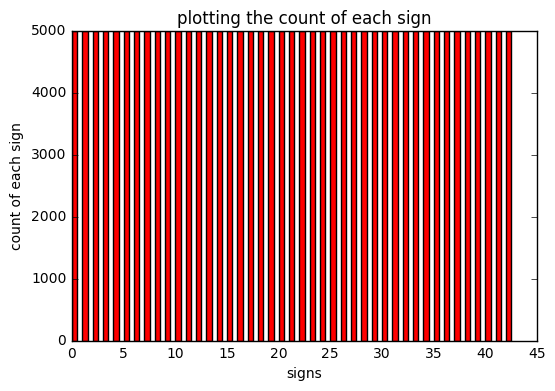

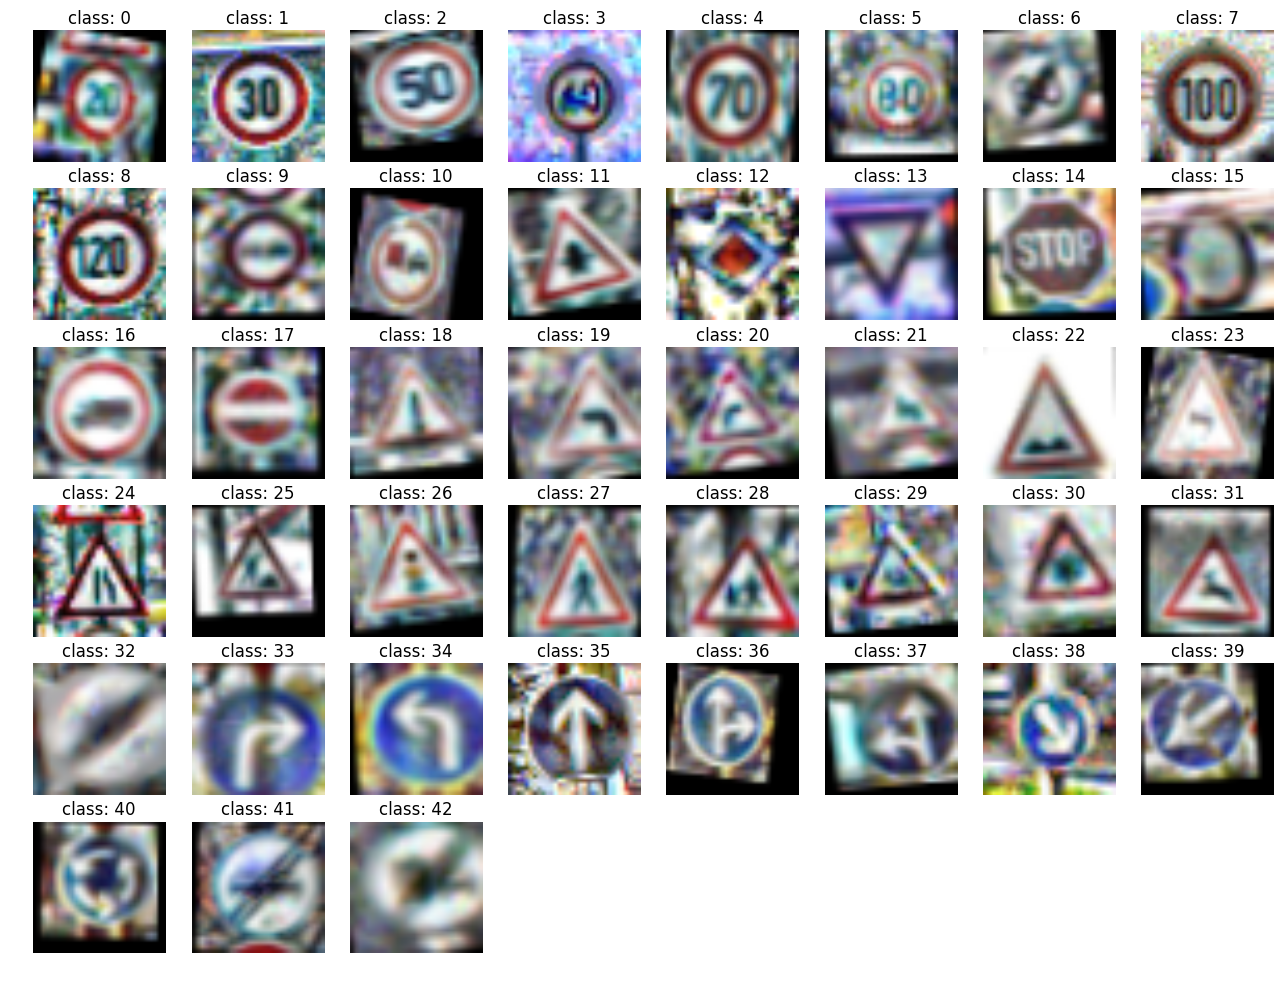

In [4]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.
import cv2
from sklearn.utils import shuffle
    
def rgb_clahe(bgr_img,limit=20,grid=4):
    b,g,r = cv2.split(bgr_img)
    clahe = cv2.createCLAHE(clipLimit=limit, tileGridSize=(grid,grid))
    b = clahe.apply(b)
    g = clahe.apply(g)
    r = clahe.apply(r)
    return cv2.merge([b,g,r])

def generate_image(img,ang_range=5,shear_range=5,trans_range=5):
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img

## Split Data
train_features = np.empty(shape=(0, 32, 32, 3), dtype=np.uint8)
valid_features = np.empty(shape=(0, 32, 32, 3), dtype=np.uint8)
train_labels = np.array([], dtype=np.uint8)
valid_labels = np.array([], dtype=np.uint8)
test_features, test_labels = X_test.copy(), y_test.copy()

for c in range(n_classes):
    indices = np.where(y_train == c)[0]
    np.random.shuffle(indices)
    valid_indices = indices[:30]
    train_indices = indices[30:]
    train_features = np.concatenate((train_features, X_train[train_indices]))
    train_labels = np.concatenate((train_labels, y_train[train_indices]))
    valid_features = np.concatenate((valid_features, X_train[valid_indices]))
    valid_labels = np.concatenate((valid_labels, y_train[valid_indices]))

## Apply CLAHE
train_features = np.array([rgb_clahe(img) for img in train_features])
valid_features = np.array([rgb_clahe(img) for img in valid_features])
test_features = np.array([rgb_clahe(img) for img in test_features])

# Generate Additional Data
new_images = []
new_labels = []
inputs_per_class = np.bincount(train_labels)
for c in range(n_classes):
    origins = np.where(train_labels == c)[0]
    for i in range(5000 - inputs_per_class[c]):
        idx = origins[i % inputs_per_class[c]]        
        new_images.append(generate_image(train_features[idx]))
        new_labels.append(c)
train_features = np.append(train_features, new_images, axis=0)
train_labels = np.append(train_labels, new_labels)

# Shuffle Train Data
train_features, train_labels = shuffle(train_features, train_labels)

# plotting the count of each sign
fig, ax = plt.subplots()
ax.bar(range(n_classes), np.bincount(train_labels), 0.5, color='r')
ax.set_xlabel('signs')
ax.set_ylabel('count of each sign')
ax.set_title('plotting the count of each sign')
plt.show()

# plotting images
plt.figure(figsize=(16, 16))
for c in range(n_classes):
    i = random.choice(np.where(train_labels == c)[0])
    plt.subplot(8, 8, c+1)
    plt.axis('off')
    plt.title('class: {}'.format(c))
    plt.imshow(train_features[i])

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In Step 0, I already have training data and test data. So I took some of the training data as validation data.

First, I shuffled all images at random and split into training and validation. But the result was in very similar sets, and was not accurately predict performance on the unseen test set. So, I extract 30 images at random per class for validation, yielding 1,290 samples for validation.

An additional challenge in training classification algorithms on the GTSRB data is that the 43 classes are not equally represented. The relative frequency of classes [0,19,37] is only 0.53%, significantly lower than the mean.

I thought balanced dataset improve on the results. So, I built a jittered dataset by geometrically transforming(translation, rotation, shear mapping) the same sign picture. This can be done easily in openCV by applying affine transformations.

In [5]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
import tensorflow as tf
from sklearn.utils import shuffle

def weight_variable(shape):
    initial = tf.truncated_normal(shape, mean=0, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.zeros(shape=shape)
    return tf.Variable(initial)

def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1], padding='VALID')
    
def conv_net(x, dropout):
    # Convolution Layer 1. 32x32x3 -> 32x32x6
    conv1_W = weight_variable([5, 5, 3, 100])
    conv1_b = bias_variable([100])
    conv1 = conv2d(x, conv1_W, conv1_b)
    
    # Pooling Layer 1. 32x32x6 -> 16x16x6
    conv1 = maxpool2d(conv1)
    
    # Convolution Layer 2. 16x16x6 -> 16x16x16
    conv2_W = weight_variable([3, 3, 100, 150])
    conv2_b = bias_variable([150])
    conv2 = conv2d(conv1, conv2_W, conv2_b)
    
    # Pooling Layer 2. 16x16x16 -> 8x8x16
    conv2 = maxpool2d(conv2)
    
    # Convolution Layer 3
    conv3_W = weight_variable([2, 2, 150, 250])
    conv3_b = bias_variable([250])
    conv3 = conv2d(conv2, conv3_W, conv3_b)
    
    conv3 = maxpool2d(conv3)
    
    # Fully Connected Layer 1. 4x4x32 -> 120
    fc1_W = weight_variable([2*2*250, 300])
    fc1_b = bias_variable([300])
    fc1 = tf.reshape(conv3, [-1, 2*2*250])
    fc1 = tf.nn.relu(tf.matmul(fc1, fc1_W) + fc1_b)
    fc1 = tf.nn.dropout(fc1, dropout)
    
    # Fully Connected Layer 3. 84 -> 43
    fc2_W = weight_variable([300, 43])
    fc2_b = bias_variable([43])
    fc2 = tf.matmul(fc1, fc2_W) + fc2_b
    return fc2

tf.reset_default_graph()
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob = tf.placeholder(tf.float32)

logits = conv_net(x, keep_prob)
loss_operation = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y))
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy, total_loss = 0, 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy =  sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * batch_x.shape[0])
        total_loss     += (loss * batch_x.shape[0])
    return total_loss / num_examples, total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

My final architecture is single CNN with seven hidden layers. The input layer has three maps of 32x32 pixels for each color channel. The output layer has 43 neurons, one for each class.

A CNN consists of a succession of convolutional and maxpooling layers, and each layer only receives connections from its previous layer. The last layer is a fully connected layer with one ouput unit per class in the recognition task.

Hidden layers are:
* Layer 1: convolutional. 100 maps of 28x28 neurons. 5x5 kernel.
* Layer 2: max pooling. 100 maps of 14x14 neurons. 2x2 kernel.
* Layer 3: convolutional. 150 maps of 12x12 neurons. 2x2 kernel.
* Lyaer 4: max pooling. 150 maps of 6x6 neurons. 2x2 kernel.
* Layer 5: convolutional. 250 maps of 5x5 neurons. 2x2 kernel.
* Layer 6: max pooling. 250 maps of 2x2 neurons. 2x2 kernel.
* Layer 7: fully connected. 300 neurons.

In [7]:
### Train your model here.
### Feel free to use as many code cells as needed.
EPOCHS = 20
BATCH_SIZE = 128
DROPOUT = 1.0

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(train_features)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        train_features, train_labels = shuffle(train_features, train_labels)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = train_features[offset:end], train_labels[offset:end]
            loss = sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: DROPOUT})
            
        validation_loss, validation_accuracy = evaluate(valid_features, valid_labels)
        print("EPOCH {} ...".format(i+1))
        print("Validation Loss     = {:.3f}".format(validation_loss))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    test_loss, test_accuracy = evaluate(test_features, test_labels)
    print("Test Loss     = {:.3f}".format(test_loss))
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    
    saver.save(sess, 'models/model.ckpt')

Training...

EPOCH 1 ...
Validation Loss     = 0.883
Validation Accuracy = 0.684

Test Loss     = 1.170
Test Accuracy = 0.602


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

* Adam optimizer with a learning rate of 0.001
* 128 batchsize
* 20 training epochs
* generate weight variables with truncated_normal function (with mean=0, stddev=0.1)
* generate bias variables with 0

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

based lenet

image preprocessing, parameter tuning

Interestingly, using colour information yielded a better performance for both architectures.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

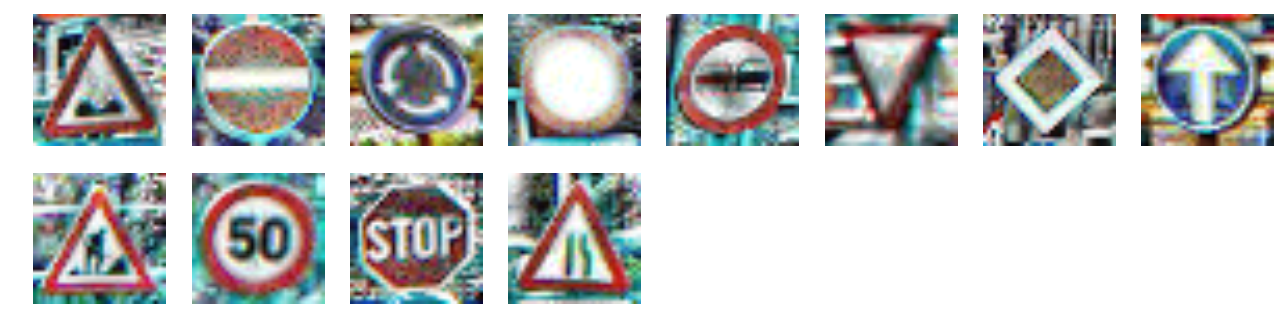

In [22]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os, fnmatch
import matplotlib.image as img

new_images = np.empty(shape=(0, 32, 32, 3), dtype=np.uint8)
for image in fnmatch.filter(os.listdir('./new_images'), '*.ppm'):
    new_images = np.concatenate((new_images, [rgb_clahe(cv2.resize(img.imread('./new_images/'+image), (32,32)))]))
    
plt.figure(figsize=(16, 16))
for i in range(len(new_images)):
    plt.subplot(8, 8, i+1)
    plt.axis('off')
    plt.imshow(new_images[i])

new_labels = np.array([22, 17, 40, 15, 9, 13, 12, 35, 25, 2, 14, 24])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

I think that the 5th and 9th images above would be difficult to classify. The former is a complex shape, and the latter is similar, but the contents are slightly different.

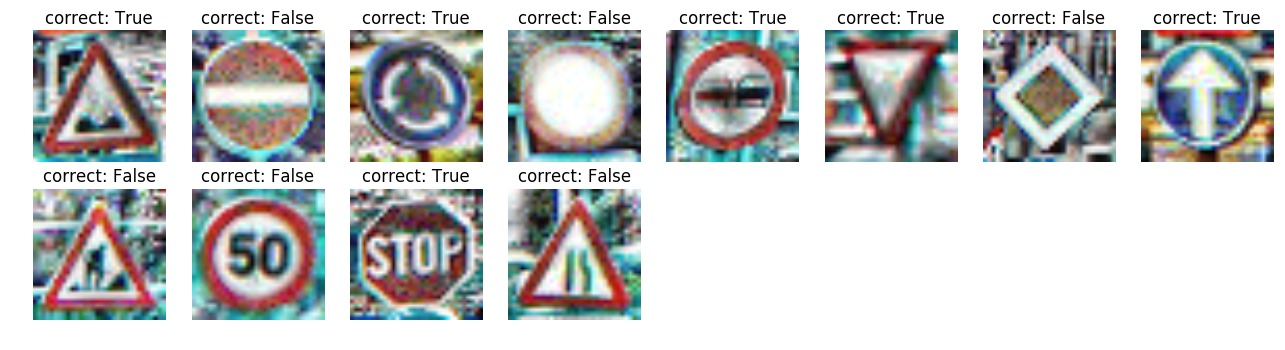

In [23]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, 'models/model.ckpt')
    predictions = sess.run(correct_prediction, feed_dict={x: new_images, y: new_labels, keep_prob: 1.})
    
    plt.figure(figsize=(16, 16))
    for i in range(len(new_images)):
        plt.subplot(8, 8, i+1)
        plt.axis('off')
        plt.title('correct: {}'.format(predictions[i]))
        plt.imshow(new_images[i])

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

I tried the test with ten images. I succeeded in accurately predicting the 8 images out of 9.

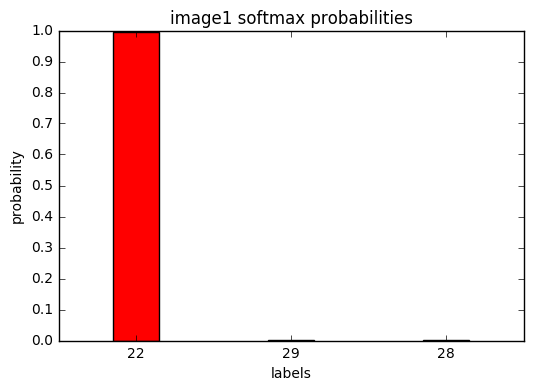

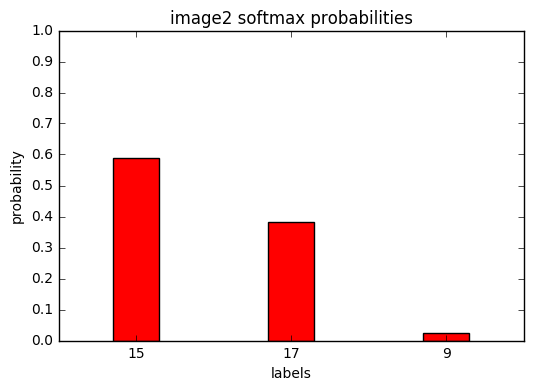

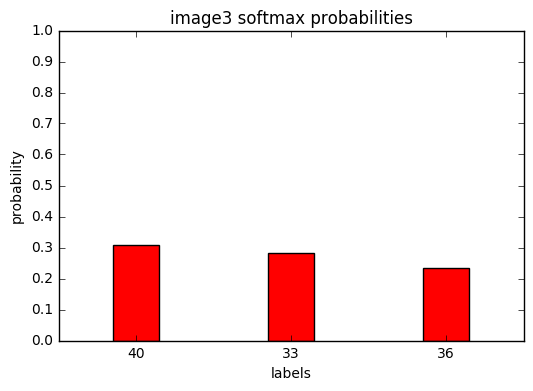

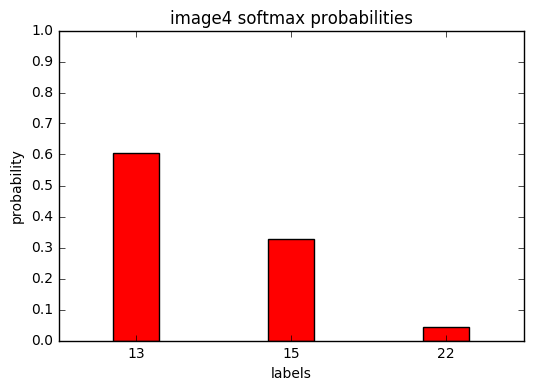

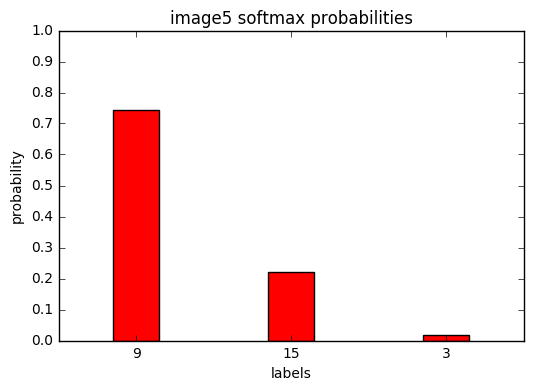

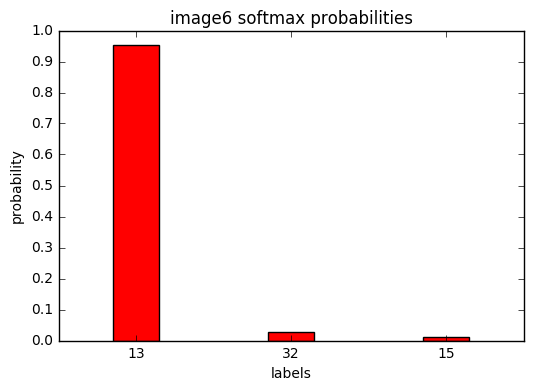

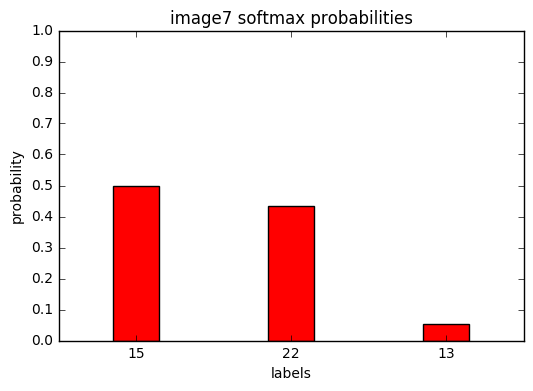

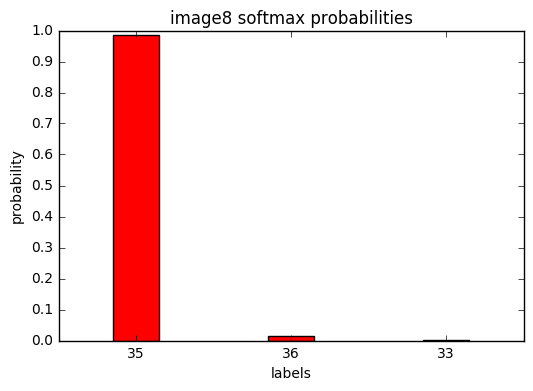

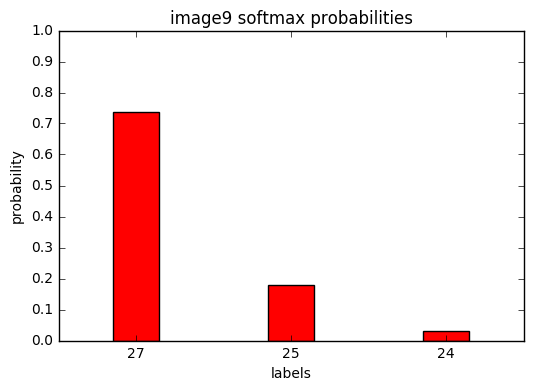

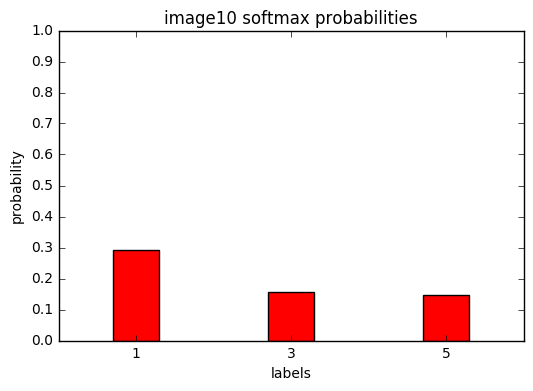

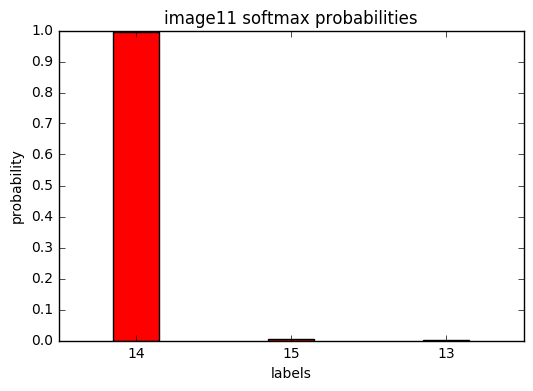

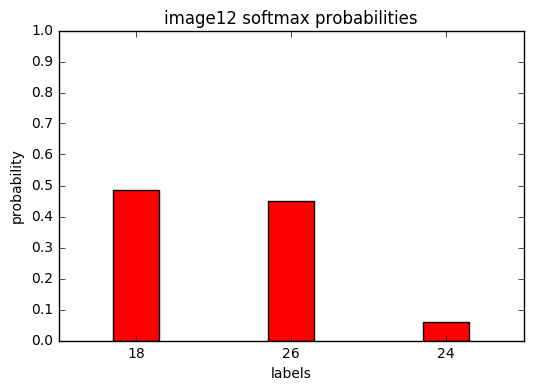

In [26]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, 'models/model.ckpt')
    probabilities = sess.run(tf.nn.top_k(tf.nn.softmax(logits), k=3), feed_dict={x: new_images, keep_prob: 1.})
    
    for i, p in enumerate(probabilities.values):
        fig, ax = plt.subplots()
        ax.bar(np.arange(3), p, 0.3, color='r', align='center')
        ax.set_xlabel('labels')
        ax.set_ylabel('probability')
        ax.set_title("image{} softmax probabilities".format(i+1))
        ax.set_xticks(np.arange(3))
        ax.set_yticks(np.arange(0, 1.1, .1))
        ax.set_xticklabels(probabilities.indices[i])
        plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.